# Path planning application

## Imports and constants

In [1]:
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt, patches
from matplotlib.lines import Line2D

from utils import (
    ROOM_DIM,
    AUDIO_PATH,
    encode,
    load_model,
    create_room,
    get_doa_MUSIC,
    normalize,
    get_CNN_prediction,
    create_observations,
)

# Model

In [4]:
class Model_pred:
    def __init__(self, model, source_loc, centre_mic, colour):
        self.room = None
        self.microphones = None
        self.centre_mic = centre_mic
        self.success = False
        self.source_loc = source_loc
        self.colour = colour
        self.model_name = model
        self.fs = 16000

        # AI related
        self.steps = 0

        if self.model_name == "CNN":
            self.encoder = encode()
            self.model = load_model("../models/saved_model", compile=True)

    def get_room(self, signal, ax):
        self.room, self.microphones = create_room(
            signal, self.fs, self.source_loc, self.centre_mic
        )
        ax.add_patch(
            patches.Circle(
                (self.centre_mic[0], self.centre_mic[1]),
                radius=0.05,
                edgecolor=self.colour,
                facecolor="none",
                linewidth=2,
            )
        )

    def get_pred(self, ax):
        pred = 0

        if self.model_name == "MUSIC":
            pred = get_doa_MUSIC(self.room, self.microphones, self.fs)

        elif self.model_name == "CNN":
            data = self.room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            X = create_observations(data, self.fs)
            pred = get_CNN_prediction(X, self.model, self.encoder)

        else:
            pass

        self.process(ax, pred)

        if not self.success:
            self.steps += 1

    def process(self, ax, pred):
        if (
            self.source_loc[0] - 0.15 < self.centre_mic[0] < self.source_loc[0] + 0.15
            and self.source_loc[1] - 0.15
            < self.centre_mic[1]
            < self.source_loc[1] + 0.15
        ):
            self.success = True
        elif 0.2 > self.centre_mic[0] > 4.8 or 0.2 > self.centre_mic[1] > 4.8:
            self.success = True
        else:
            self.update_centre(ax, pred)

    def update_centre(self, ax, pred):
        x_align = self.centre_mic[0] + 0.3 * np.cos(pred)
        y_align = self.centre_mic[1] + 0.3 * np.sin(pred)

        if not x_align == False:
            ax.add_patch(
                patches.Arrow(
                    self.centre_mic[0],
                    self.centre_mic[1],
                    0.3 * np.cos(pred),
                    0.3 * np.sin(pred),
                    width=0.1,
                    edgecolor=self.colour,
                    facecolor=self.colour,
                )
            )

            self.centre_mic = [x_align, y_align]

## Visualization

MUSIC time taken: 0.0023s
370/370 [==============================] - 0s 723us/step
CNN prediction time: 0.3557s
MUSIC time taken: 0.0027s
370/370 [==============================] - 0s 891us/step
CNN prediction time: 0.3959s
MUSIC time taken: 0.0022s
370/370 [==============================] - 0s 785us/step
CNN prediction time: 0.3543s
MUSIC time taken: 0.0021s
370/370 [==============================] - 0s 713us/step
CNN prediction time: 0.3230s
MUSIC time taken: 0.0021s
370/370 [==============================] - 0s 682us/step
CNN prediction time: 0.3138s
MUSIC time taken: 0.0021s
370/370 [==============================] - 0s 712us/step
CNN prediction time: 0.3216s
MUSIC time taken: 0.0021s
370/370 [==============================] - 0s 675us/step
CNN prediction time: 0.3079s
MUSIC time taken: 0.0019s
369/369 [==============================] - 0s 692us/step
CNN prediction time: 0.3113s
MUSIC time taken: 0.0021s
369/369 [==============================] - 0s 729us/step
CNN prediction time: 

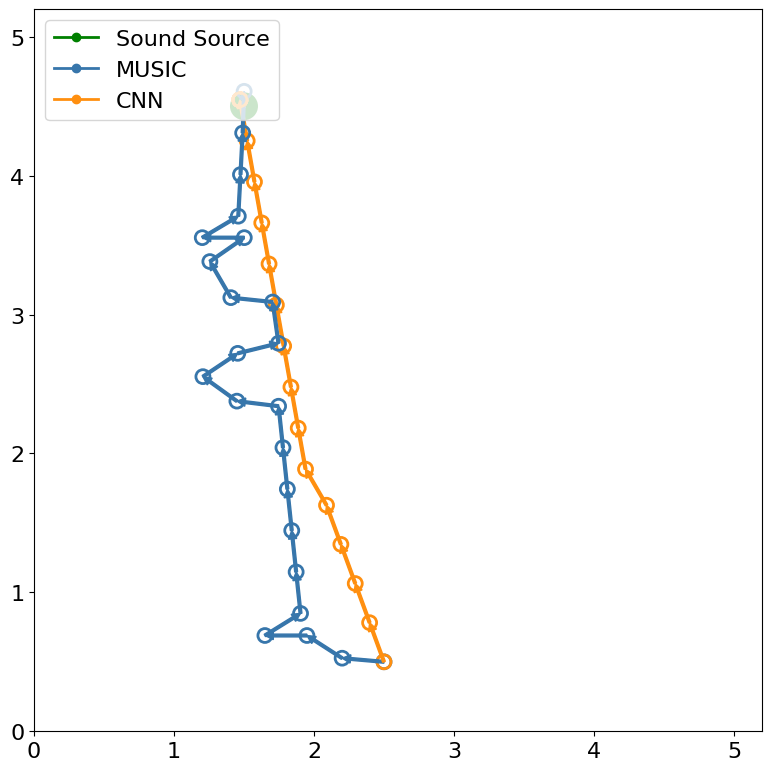

In [5]:
microphones = np.c_[[ROOM_DIM[0]/2-0.1, 0.5, 0], [ROOM_DIM[0]/2+0.1, 0.5, 0]]
source_loc = [float(1.5), float(4.5)]
centre_mic = [2.5, 0.5]

plt.rcParams.update({'figure.figsize': [8,8], 'figure.autolayout': True, 'font.size': 16})
fig, _ = plt.subplots()
ax = plt.gca()
ax.set_xlim([0, 5.2])
ax.set_ylim([0, 5.2])

# Include sound source patch
sound = patches.Circle((float(source_loc[0]), float(source_loc[1])), radius=0.1, facecolor='green', linewidth=5, label='Sound Source')
ax.add_patch(sound)

# Include custom legend
legend_elements = [Line2D([0], [0], marker='o', lw=2, color='green',   label='Sound Source'),
                   Line2D([0], [0], marker='o', lw=2, color='#3776ab', label='MUSIC'),
                   Line2D([0], [0], marker='o', lw=2, color="#ff8f0f", label='CNN')]
ax.legend(handles=legend_elements, loc='upper left')

# Initialize models
MUSIC = Model_pred('MUSIC', source_loc, centre_mic, '#3776ab')
CNN = Model_pred('CNN', source_loc, centre_mic, '#ff8f0f')
i = 0

# Generate predictions
while MUSIC.success == False or CNN.success == False:
    # Generate room
    fs, signal = wavfile.read(AUDIO_PATH)
    MUSIC.get_room(signal, ax)
    CNN.get_room(signal, ax)

    # Localize sound
    MUSIC.get_pred(ax)
    CNN.get_pred(ax)
    
    i += 1
    plt.savefig("../pygame/path_ideal/path_ideal_%02d.png"%i)
    plt.show

# Display the number of steps taken
print("MUSIC steps: ", MUSIC.steps)
print("CNN steps: ", CNN.steps)